In [2]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [3]:
from helpers import load_data, preprocess_data

path_dataset = "movielens100k.csv"
ratings = load_data(path_dataset)

number of items: 1682, number of users: 943


In [4]:
print(ratings.nonzero()[0].size)

99999


### Plot the number of ratings per movie and user

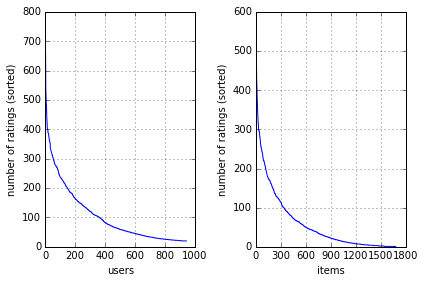

min # of items per user = 20, min # of users per item = 1.


In [5]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [6]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]
    
    # initialization
    p_test = 0.1
    train = valid_ratings.copy()
    test = valid_ratings.copy()
    
    # split the data and return train and test data.
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    for u in range(valid_ratings.shape[1]):
        non_zero_ratings = valid_ratings[:, u].nonzero()
        mask_test = np.random.choice(2, non_zero_ratings[0].shape, p=[1-p_test, p_test]).astype(bool)
        test_idxs = non_zero_ratings[0][mask_test]
        train_idxs = non_zero_ratings[0][~mask_test]
        train[test_idxs, u] = 0
        test[train_idxs, u] = 0
    
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:99999
Total number of nonzero elements in train data:88208
Total number of nonzero elements in test data:9744


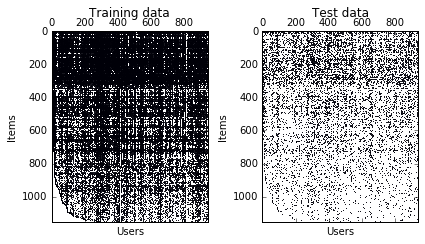

In [7]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [51]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    num_items, num_users = test.shape
    error = 0
    
    # Compute the global mean
    global_mean = train.sum()/train.nnz
    
    # Compute the RMSE
    tst_nz_idx = test.nonzero()
    mse_test = 1/test.nnz * calculate_mse(test[tst_nz_idx].toarray()[0], global_mean)
    tr_nz_idx = train.nonzero()
    mse_train = 1/train.nnz * calculate_mse(train[tr_nz_idx].toarray()[0], global_mean)
    return global_mean, np.sqrt(mse_train), np.sqrt(mse_test)

baseline_global_mean(train, test)

(3.5464923816433882, 1.1157467813075499, 1.1228696853060485)

### Use the user means as the prediction

In [52]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    # Compute mean for every users
    means = np.array(train.sum(axis=0)/train.getnnz(axis=0))[0]
    
    # Compute the RMSE
    tst_nz_idx = test.nonzero()
    mse_test = 1/len(tst_nz_idx[1]) * calculate_mse(test[tst_nz_idx].toarray()[0], means[tst_nz_idx[1]])
    tr_nz_idx = train.nonzero()
    mse_train = 1/len(tr_nz_idx[1]) * calculate_mse(train[tr_nz_idx].toarray()[0], means[tr_nz_idx[1]])
    return means, np.sqrt(mse_train), np.sqrt(mse_test)
   

baseline_user_mean(train, test)

(array([ 3.6460177 ,  3.75471698,  2.72916667,  4.33333333,  2.98675497,
         3.62433862,  3.98300283,  3.75      ,  4.23809524,  4.17964072,
         3.46783626,  4.43478261,  3.19101124,  4.05376344,  2.88297872,
         4.27642276,  2.96      ,  3.86585366,  3.5625    ,  3.13043478,
         2.73648649,  3.36936937,  3.57480315,  4.28813559,  4.05633803,
         2.97802198,  3.29166667,  3.75714286,  3.61290323,  3.74358974,
         4.        ,  3.2972973 ,  3.7       ,  4.        ,  3.04347826,
         3.8       ,  3.65384615,  3.72477064,  3.88235294,  2.86666667,
         3.78      ,  3.6809816 ,  3.68292683,  3.68656716,  3.57142857,
         4.04166667,  3.60869565,  3.79310345,  2.64397906,  3.60869565,
         3.8       ,  4.25454545,  3.88      ,  3.64285714,  3.4       ,
         3.64285714,  3.50515464,  3.8359375 ,  3.92977528,  4.0802139 ,
         2.64705882,  3.28358209,  3.1       ,  3.56216216,  3.91044776,
         3.48571429,  3.81481481,  3.        ,  3.8

### Use the item means as the prediction

In [53]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    # Compute mean for every users
    means = np.array(train.sum(axis=1).T/train.getnnz(axis=1))[0]
    
    # Compute the RMSE
    tst_nz_idx = test.nonzero()
    mse_test = 1/len(tst_nz_idx[0]) * calculate_mse(test[tst_nz_idx].toarray()[0], means[tst_nz_idx[0]])
    tr_nz_idx = train.nonzero()
    mse_train = 1/len(tr_nz_idx[0]) * calculate_mse(train[tr_nz_idx].toarray()[0], means[tr_nz_idx[0]])
    return means, np.sqrt(mse_train), np.sqrt(mse_test)

baseline_item_mean(train, test)

(array([ 3.8808933 ,  3.18333333,  2.98666667, ...,  3.        ,
         2.8       ,  3.        ]), 0.99843307637045664, 1.0177681536812451)

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [34]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    num_item, num_user = train.shape
    user_features = np.random.randn(num_features, num_user)
    item_features = np.random.randn(num_features, num_item)
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [109]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (RMSE) of the prediction of nonzero elements."""
    loss = 0
    #prediction = np.zeros(data.shape)
    nz_data = np.array([data[d,n] for (d,n) in nz])
    prediction = np.array([(np.dot(item_features[:, d].T,(user_features[:,n]))) for (d,n) in nz])
    return np.sqrt(1/len(nz) * calculate_mse(nz_data, prediction))

In [48]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    num_item, num_user = train.shape
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):   
        # decrease step size
        gamma /= 1.2
        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # Matrix factorization
        for d, n in nz_train:
            # Calculate Gradient
            error = train[d, n] - (item_features[:, d].T @ user_features[:, n])
            gradient = np.zeros((num_item + num_user, num_features))
            gradient[d, :] = - error * user_features[:, n].T + lambda_item * item_features[:, d].T
            gradient[num_item + n, :] = - error * item_features[:, d].T + lambda_user * user_features[:, n].T
            
            # Update W and Z
            item_features = item_features - gamma*gradient[:num_item,:].T
            user_features = user_features - gamma*gradient[num_item:,:].T
        # Add regularizer
        rmse_train = compute_error(train, user_features, item_features, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse_train))
        
        errors.append(rmse_train)
    # Compute the test error.
    rmse = compute_error(test, user_features, item_features, nz_test)
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)   

learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 2.059216052651851.
iter: 1, RMSE on training set: 1.3468209923454637.
iter: 2, RMSE on training set: 1.1470776905820537.
iter: 3, RMSE on training set: 1.0706657366487098.
iter: 4, RMSE on training set: 1.0277411230289748.
iter: 5, RMSE on training set: 1.0029145324965991.
iter: 6, RMSE on training set: 0.9885232819700887.
iter: 7, RMSE on training set: 0.977875395511943.
iter: 8, RMSE on training set: 0.9723756484424024.
iter: 9, RMSE on training set: 0.9674810177526744.
iter: 10, RMSE on training set: 0.9640748644578293.
iter: 11, RMSE on training set: 0.9614616700503408.
iter: 12, RMSE on training set: 0.9592037398233295.
iter: 13, RMSE on training set: 0.9579173909072751.
iter: 14, RMSE on training set: 0.9561843183670065.
iter: 15, RMSE on training set: 0.9553509871443057.
iter: 16, RMSE on training set: 0.9543228393765157.
iter: 17, RMSE on training set: 0.9535911075551337.
iter: 18, RMSE on training set: 

### Learn the Matrix Factorization using Alternating Least Squares

In [114]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    num_users = train.shape[1]
    K = item_features.shape[0]
    Z = np.zeros((K, num_users))
    
    for n in range(num_users):
        nz_item_features_per_user = item_features[:, nz_user_itemindices[n]]
        A = nz_item_features_per_user @ nz_item_features_per_user.T + nnz_items_per_user[n] * lambda_user*np.eye(K)
        train_per_user_nz_items=train[nz_user_itemindices[n],n]
        B = nz_item_features_per_user @ train_per_user_nz_items
        Z[:, n] = np.linalg.solve(A, B)[0]
    return Z

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    num_items = train.shape[0]
    K = user_features.shape[0]
    W = np.zeros((K, num_items))
    
    for d in range(num_items):
        nz_user_features_per_item = user_features[:, nz_item_userindices[d]]
        A = nz_user_features_per_item @ nz_user_features_per_item.T + nnz_users_per_item[d]*lambda_item*np.eye(K)
        train_per_item_nz_users=train[d,nz_item_userindices[d]]
        B = nz_user_features_per_item @ train_per_item_nz_users.T
        W[:, d] = np.linalg.solve(A, B)[0]
    return W

In [115]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    item_means, _, _ = baseline_item_mean(train, train)
    num_item, num_user = train.shape
    item_features = np.random.randn(num_features, num_item)
    item_features[0,:] = item_means
    user_means, _, _ = baseline_user_mean(train, train)
    user_features = np.random.randn(num_features, num_user)
    user_features[0,:] = user_means
    return user_features, item_features

In [116]:
from helpers import build_index_groups


def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [0, 0]
    max_iter = 10
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # Calculate arguments for the update of Z and W
    nnz_items_per_user = train.getnnz(axis=0)
    nnz_users_per_item = train.getnnz(axis=1)
    nz_user_itemindices = []
    nz_item_userindices = []
    nz_train, nz_row_colindices, nz_col_rowindices= build_index_groups(train)

    for row,colindices in nz_row_colindices:
        nz_item_userindices.append(colindices)
    for col,rowindices in nz_col_rowindices:
        nz_user_itemindices.append(rowindices)
    
    for it in range(max_iter):        
        # Fix W. Solve Z
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        # Fix Z. Solve W
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        nz_row, nz_col = train.nonzero()
        nz_train = list(zip(nz_row, nz_col))
        print(compute_error(train, user_features, item_features, nz_train))
    return user_features, item_features
ALS(train, test)

LinAlgError: Singular matrix